In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install scipy

## Importing require dependencies and starting a spark context.

In [3]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/numpy_pack.py','lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

#!pip install pandas
#!pip install scipy

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time

Populating the interactive namespace from numpy and matplotlib


## Loading the Dataset and Parsing the Rows

In [4]:
import sys
sys.path.append('lib')
from row_parser import *

Parse_rules,field_names,RowObject = init_parser_parameters()

from pyspark.sql import DataFrame

CVS_Data=sc.textFile("/CVS/*/")


def parse(row):
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)


RDD=CVS_Data.map(parse)

df=sqlContext.createDataFrame(RDD)

('time', 'datetime') {'start': 0, 'parser': <function parse_date at 0x7f90faf87410>, 'end': 1, 'name': 'time'}
('species', 'str') {'start': 1, 'parser': <function parse_string at 0x7f90faf875f0>, 'end': 2, 'name': 'species'}
('site', 'str') {'start': 2, 'parser': <function parse_string at 0x7f90faf875f0>, 'end': 3, 'name': 'site'}
('rec_no', 'str') {'start': 3, 'parser': <function parse_string at 0x7f90faf875f0>, 'end': 4, 'name': 'rec_no'}
('bout_i', 'int') {'start': 4, 'parser': <function parse_int at 0x7f90faf87500>, 'end': 5, 'name': 'bout_i'}
('peak2peak', 'float') {'start': 5, 'parser': <function parse_float at 0x7f90faf87578>, 'end': 6, 'name': 'peak2peak'}
('MSN', 'array', 202) {'start': 6, 'parser': <function parse_array at 0x7f90faf87488>, 'end': 208, 'name': 'MSN'}
('MSP', 'array', 101) {'start': 208, 'parser': <function parse_array at 0x7f90faf87488>, 'end': 309, 'name': 'MSP'}
('TPWS1', 'bool') {'start': 309, 'parser': <function parse_int at 0x7f90faf87500>, 'end': 310, 'n

In [5]:
## Caching the Dataframe
df = df.filter(df.TPWS2==1).filter(df.MD2==0).filter(df.FD2==0)
df.cache().count()

4144531

## Mean and covariance
### 12:85 is chosen because only the ones in that range matters to distinguish from whale types ( as mentioned by the whale expert) 

In [2]:
from time import time
from spark_PCA import *
COV=computeCov(spectra)

M=COV['Mean']
S=np.sqrt(COV['Var'])
plot(M-S)
plot(M)
plot(M+S)

plot(np.sqrt(COV['Var']))

ImportError: No module named spark_PCA

## Functions to Read MSP

In [6]:
from spark_PCA import *
from row_parser import unpackArray

def trimmed_spectra(row):
    return unpackArray(row.MSP,data_type=numpy.float64)[12:85] 

def unpackArray(x,data_type=numpy.int16):
    return np.frombuffer(x,dtype=data_type)

## Eigen Vector Extraction

shape of E= (73,) shape of NE= (73,)


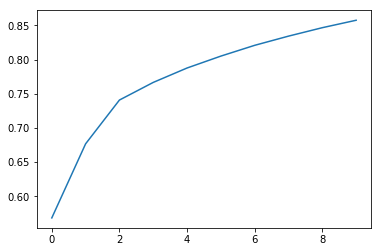

In [8]:
## Get Spectra
spectra=df.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
plot(cumsum(eigval[:10]))

## Visualizing the first 4 eigen vectors

In [ ]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

Can be seen that the sum of all eigen vectors is 1

In [ ]:
sum(eigvec[:,1]**2)

In [9]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]

## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

## Creating Training Data

### Filtering Samples

Only taking the samples which were neither Misclassified (MS = 0) nor Falsely Detected (FD = 0)

In [18]:
def filtering(row):
    array = trimmed_spectra(row)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [19]:
df_filtered_data = df.rdd.map(filtering)

In [21]:
data = df_filtered_data.collect()

## Writing Data

In [35]:
np_data = np.array(data)
np.save(open('data.np', 'wb'), np_data)

In [36]:
!hadoop fs -copyFromLocal data.np s3://whales-classification/

18/03/03 04:12:18 INFO s3n.MultipartUploadOutputStream: uploadPart /mnt/s3/emrfs-4346093023447560674/0000000000 134217728 bytes md5: QgiMKRovgLSzmxkBvHJUKw== md5hex: 42088c291a2f80b4b39b1901bc72542b
18/03/03 04:12:19 INFO s3n.MultipartUploadOutputStream: uploadPart /mnt/s3/emrfs-4346093023447560674/0000000001 134217728 bytes md5: XYE8bkN9fjKuznoh6rbHdg== md5hex: 5d813c6e437d7e32aece7a21eab6c776
18/03/03 04:12:19 INFO s3n.MultipartUploadOutputStream: uploadPart /mnt/s3/emrfs-4346093023447560674/0000000002 134217728 bytes md5: F7lcK9wi/aKwhrs2u3Rs1A== md5hex: 17b95c2bdc22fda2b086bb36bb746cd4
18/03/03 04:12:19 INFO s3n.MultipartUploadOutputStream: close closed:false s3://whales-classification/data.np
18/03/03 04:12:19 INFO s3n.MultipartUploadOutputStream: uploadPart /mnt/s3/emrfs-4346093023447560674/0000000003 28378120 bytes md5: bNLKMkA6UHA3h9SVr54R3g== md5hex: 6cd2ca32403a50703787d495af9e11de
18/03/03 04:12:22 INFO s3n.MultipartUploadOutputStream: uploadPart /mnt/s3/emrfs-43460930234475

## Additional Analysis

In [4]:
Cuviers=df.filter(df.TPWS2==1).filter(df.species==u'Cuviers')
Gervais=df.filter(df.TPWS2==1).filter(df.species==u'Gervais')

NameError: name 'df' is not defined

In [ ]:
V=eigvec[:,1:3] #vectors on which to project, chose 1,2,3 eigen vectors
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

Scatter plot shows there is are some points which are classified as a particular spiecies in high confidence and the rest are unsure.

In [ ]:
Cuvier_projections=np.array(Cuviers.sample(False,0.001).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.001).rdd.map(project).take(10000))


figure(figsize=[13,10])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r')
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b')
xlim([-200,-50])
ylim([-50,50])